# Clustering Social Media Data

In [90]:
#!pip install umap-learn
#python -m pip install umap

In [91]:
import numpy as np
import pandas as pd
import pickle
from os import path as Path
import datetime
import numpy as np
from sklearn import datasets
import json

# Plotting libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension-reduction and clustering libs
from sklearn.manifold import TSNE
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [92]:
input_data=pd.read_pickle("../data/mebank_tweets_1_year_embeddings.pkl")
input_data.tail(1)

,date,content,content_clean,complaint,topic,embedding
861,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,making beautiful banking and helping australia...,0,NaN,"[-0.13470693, 0.11104454, 0.031296838, 0.06003..."


# Exploratory data analysis

In [93]:
input_data.describe()

,complaint
count,862.000000
mean,0.361949
std,0.480843
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [94]:
#dataset["topic"]=dataset['topic'].fillna('NA')
input_data["topic"].value_counts()

problem/customer service      76
problem/system down           74
problem/others                50
problem/app                   33
problem/transaction           31
problem/financial products    29
inquiry                        7
feature request                7
problem/website                5
others                         5
problem/atm                    2
fraud                          2
sustainability                 2
Name: topic, dtype: int64

# Splitting the data


Splitting the data for unsupervised clustering (comparing over time)

In [95]:
# convert date from str to date format
input_data['date']=input_data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
type(input_data['date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [96]:
input_data_2020 = input_data[(input_data['date']> datetime.datetime(year=2020,month=1,day=1)) \
	& (input_data['date']< datetime.datetime(year=2021,month=1,day=1))]

input_data_2021 = input_data[(input_data['date']>= datetime.datetime(year=2021,month=1,day=1))]

In [98]:
# saving splitted data
input_data_2020.to_csv("../data/mebank_tweets_2020_embedding.csv", index=False)
input_data_2021.to_csv("../data/mebank_tweets_2021_embedding.csv", index=False)

#input_data_2020.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_2020_embedding.csv", index=False)
#input_data_2021.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_2021_embedding.csv", index=False)

# UMAP & HDBSCAN

UMAP Model

In [558]:
# Define UMAP model to reduce embeddings dimension
n_neighbors=15    #smaller -> more local, larger: global structure, more uniform density
n_components=50    
min_dist=0.01      # min distance in projected space (0 or small value)

umap_model = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=123,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='euclidean',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1 #giving keeping densities some weight
                       )

umap_model_2020 = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=123,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1 #giving keeping densities some weight
                       )

umap_model_2021 = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=123,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1                     
                       )

umap_model_1year = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=123,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1                     
                       )

In [ ]:
umap_model.fit_transform(input_data_2020['embedding'].values.tolist())
umap_model_2020.fit_transform(input_data_2020['embedding'].values.tolist())
umap_model_2021.fit_transform(input_data_2021['embedding'].values.tolist())
umap_model_1year.fit_transform(input_data['embedding'].values.tolist())

Projecting embeddings into lower dimentional space using UMAP

In [560]:
umap_embeddings=umap_model.embedding_
umap_embeddings_2020=umap_model.transform(input_data_2020['embedding'].values.tolist())
umap_embeddings_2021=umap_model.transform(input_data_2020['embedding'].values.tolist())
umap_embeddings_1year=umap_model.transform(input_data['embedding'].values.tolist())

Visualizing UMAP projection

In [545]:
def draw_umap(umap_model, data, n_components=2, title=''):

    u = umap_model.transform(data);
    #u=np.array(data)
    
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,1], range(len(u)), c=range(len(data)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=range(len(data)))
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=range(len(data)), s=100)
    plt.title(title, fontsize=18)

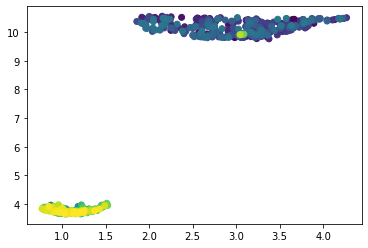

In [561]:
data=input_data['embedding'].values.tolist()
draw_umap(umap_model, data, n_components=2)

HDBSCAN Model

In [538]:
# Define HDBSCAN model to perform documents clustering

# Parameters: 
# (a) min_cluster_size: min cluster size
# (b) min_sample: the larger the value of min_samples you provide, the more conservative the clustering 
#    – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. 
# (c): cluster_selection_epsilon=epsilon, #useful to avoid micro-clusters when we have different densities and small min_cluster size
# (d) cluster_selection_method: eom (stability based) or leaf

epsilon=0
min_cluster_size=5;
min_samples=3


hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric='euclidean',
                                cluster_selection_epsilon=epsilon, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )

hdbscan_model_2020 = hdbscan.HDBSCAN(min_cluster_size=3,
                                min_samples=3,
                                metric='euclidean',
                                cluster_selection_epsilon=0, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )

hdbscan_model_2021 = hdbscan.HDBSCAN(min_cluster_size=3,
                                min_samples=3,
                                metric='euclidean',
                                cluster_selection_epsilon=0, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )

hdbscan_model_1year = hdbscan.HDBSCAN(min_cluster_size=3,
                                min_samples=3,
                                metric='euclidean',
                                cluster_selection_epsilon=0, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )


Clusterin embeddings directly (not recommended, hdbscan is suitable for upto 50 or max 100 features)

In [501]:
hdbscan_cluster = hdbscan_model.fit(input_data_2020['embedding'].values.tolist())
hdbscan_cluster_2020 = hdbscan_model_2020.fit(input_data_2020['embedding'].values.tolist())
hdbscan_cluster_2021 = hdbscan_model_2021.fit(input_data_2021['embedding'].values.tolist())
hdbscan_cluster_1year = hdbscan_model_1year.fit(input_data['embedding'].values.tolist())

Clusterin umap projections using HDBSAN

In [540]:
hdbscan_cluster = hdbscan_model.fit(umap_embeddings_2020)
hdbscan_cluster_2020 = hdbscan_model_2020.fit(umap_embeddings_2020)
hdbscan_cluster_2021 = hdbscan_model_2021.fit(umap_embeddings_2021)
hdbscan_cluster_1year = hdbscan_model_1year.fit(umap_embeddings_1year)

In [541]:
print(hdbscan_cluster_2020.labels_[:20])
print(hdbscan_cluster_1year.labels_[:20])

print(hdbscan_cluster_2021.labels_[-20:])
print(hdbscan_cluster_1year.labels_[-20:])

[ 9 14 12 12 -1 13 22 22 26 15 -1  2 19 -1 -1 12 12 -1  3  3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [497]:
hdbscan_cluster_2020_2021_labels, hdbscan_cluster_2020_2021_strengths = hdbscan.approximate_predict(hdbscan_cluster_2020, umap_embeddings_2021)

#hdbscan_cluster_2020_2021_fit = hdbscan_model_2020.fit_predict(umap_embeddings_2021[-200:])


print(hdbscan_cluster_2021.labels_[-20:])
print(hdbscan_cluster_2020_2021_labels[-20:])
#print(hdbscan_cluster_2020_2021_fit[-20:])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


<AxesSubplot:ylabel='distance'>

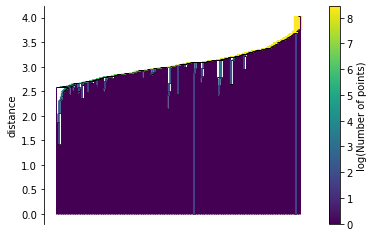

In [480]:
#hdbscan_cluster_2020.condensed_tree_.plot()
hdbscan_cluster_2020.single_linkage_tree_.plot()

In [2397]:
#cluster_labels=hdbscan_cluster.single_linkage_tree_.get_clusters(0.4, min_cluster_size=5)
#cluster_labels

In [292]:
hdbscan_cluster_1year.cluster_persistence_
#sum(hdbscan_cluster_1year.cluster_persistence_)

array([0.38183987, 0.03057986, 0.19463296, 0.26065108, 0.07743952,
       0.05054897, 0.42135752, 0.4384817 , 0.00954941, 0.26319883,
       0.08122959, 0.48300232, 0.13921133, 0.00720225, 0.08671946,
       0.02751336, 0.04124117, 0.03870916])

In [ ]:
results_2020=input_data_2020
results_2020['umap_projections']=list(umap_embeddings_2020)
results_2020['cluster']=hdbscan_cluster_2020.labels_
results_2020['cluster_probability']=hdbscan_cluster_2020.probabilities_
results_2020['outlier_score']=hdbscan_cluster_2020.outlier_scores_

results_2021=input_data_2021
results_2021['umap_projections']=list(umap_embeddings_2021)
results_2021['cluster']=hdbscan_cluster_2021.labels_
results_2021['cluster_probability']=hdbscan_cluster_2021.probabilities_
results_2021['outlier_score']=hdbscan_cluster_2021.outlier_scores_

results_1year=input_data
results_1year['umap_projections']=list(umap_embeddings_1year)
results_1year['cluster']=hdbscan_cluster_1year.labels_
results_1year['cluster_probability']=hdbscan_cluster_1year.probabilities_
results_1year['outlier_score']=hdbscan_cluster_1year.outlier_scores_
results_1year.sample(3)

In [293]:
#finding outliers
outliers_2020=results_2020.loc[results_2020['cluster'].isin([-1])]
outliers_2020.shape

(30, 10)

In [ ]:
#clustered data
clustered_2020 = results_2020.loc[~results_2020['cluster'].isin([-1])]
clustered_2020.sort_values(by='cluster')[150:200]

In [698]:
#SAVING RESULTS (Clustering outcome)
results_2020.sort_values(by='date')
results_2020.to_csv('../data/mebank_tweets_2020_results_sorted_by_date.csv', index=False)

results_2021.sort_values(by='date')
results_2021.to_csv('../data/mebank_tweets_2021_results_sorted_by_date.csv', index=False)

results_1year.sort_values(by='date')
results_1year.to_csv('../data/mebank_tweets_1_year_results_sorted_by_date.csv', index=False)

#results.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_date.csv",index=False)

In [699]:
#SAVING CLUSTER LIST
results_2020_sorted=results_2020.sort_values(by='cluster')
results_2020_sorted.to_csv('../data/mebank_tweets_2020_results_sorted_by_cluster.csv', index=False)

results_2021_sorted=results_2021.sort_values(by='cluster')
results_2021_sorted.to_csv('../data/mebank_tweets_2021_results_sorted_by_cluster.csv', index=False)

results_1year_sorted=results_1year.sort_values(by='cluster')
results_1year_sorted.to_csv('../data/mebank_tweets_1_year_results_sorted_by_cluster.csv', index=False)

#results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_clusters_sorted_by_cluster.csv",index=False)

# Quantitative Model Evaluation

In [586]:
#from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

#adjusted_rand_score(dataset['topic'], result['labels']), adjusted_mutual_info_score(dataset['topic'], result['labels'])

(0.031164243259547558, 0.20168266687017464)

# Topic Modelling

In [840]:
results_2020.sample()

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
151,2020-10-01 00:10:06,@mebank @Canstar Shame about:\n\nhttps://t.co/...,shame about:,0,NaN,"[0.06984109, 0.19706956, -0.07923282, 0.023760...","[-1.3466363, 17.201218, 16.707275, 5.087572, 5...",4,1.0,0.0


In [841]:
def get_docs_per_topic(df):
	docs_df= pd.DataFrame()
	docs_df['Doc']=df['content']
	docs_df['Doc_Clean']=df['content_clean']
	docs_df['Topic'] = df['cluster']
	docs_df['Doc_ID'] = range(len(docs_df))
	docs_per_topic_raw = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
	docs_per_topic_clean = docs_df.groupby(['Topic'], as_index = False).agg({'Doc_Clean': ' '.join})
	docs_per_topic=pd.merge(docs_per_topic_raw, docs_per_topic_clean, on=["Topic"])
	
	return docs_df, docs_per_topic


docs_df_2020, docs_per_topic_2020=get_docs_per_topic(results_2020)
docs_df_2021, docs_per_topic_2021=get_docs_per_topic(results_2021)
#doc_df_1year, docs_per_topic_1year=get_docs_per_topic(results_1year)

In [1213]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


tf_idf_2020, count_2020 = c_tf_idf(docs_per_topic_2020.Doc_Clean.values, m=len(results_2020))
tf_idf_2021, count_2021 = c_tf_idf(docs_per_topic_2021.Doc_Clean.values, m=len(results_2021))
#tf_idf_1year, count_1year = c_tf_idf(docs_per_topic_1year.Doc_Clean.values, m=len(results_1year))

In [843]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc_Clean
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc_Clean": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


top_n_words_2020 = extract_top_n_words_per_topic(tf_idf_2020, count_2020, docs_per_topic_2020, n=10)
topic_sizes_2020 = extract_topic_sizes(docs_df_2020)

top_n_words_2021 = extract_top_n_words_per_topic(tf_idf_2021, count_2021, docs_per_topic_2021, n=10)
topic_sizes_2021 = extract_topic_sizes(docs_df_2021)

In [844]:
top_n_words_2020[8]

[('app', 0.06068483574541008),
 ('banking', 0.04184690187897141),
 ('working', 0.04128418363972292),
 ('internet', 0.0344267934295597),
 ('online', 0.0344267934295597),
 ('internet banking', 0.030661635248973005),
 ('atm', 0.028043379081033493),
 ('fix', 0.028043379081033493),
 ('log', 0.028043379081033493),
 ('issue', 0.02711387132634304)]

In [845]:
np.array(top_n_words_2020[-1])[:,0]
#list(np.array(top_n_words[-1])[:,1])

array(['money', 'new', 'days', 'card', 'customer', 'account', 'just',
       'hold', 'mebank', 'pay'], dtype='<U32')

In [846]:
# Creating a variable for results
clustering_results_2020=docs_per_topic_2020

clustering_results_2020['cluster_size']=topic_sizes_2020['Size']

for i,topic in enumerate(clustering_results_2020['Topic']):
	clustering_results_2020.loc[i,'top_words']=str(list(np.array(top_n_words_2020[topic])[:,0]))
	clustering_results_2020.loc[i,'top_words_score']=str(top_n_words_2020[topic])


# Creating a variable for results
clustering_results_2021=docs_per_topic_2021

clustering_results_2021['cluster_size']=topic_sizes_2021['Size']

for i,topic in enumerate(clustering_results_2021['Topic']):
	clustering_results_2021.loc[i,'top_words']=str(list(np.array(top_n_words_2021[topic])[:,0]))
	clustering_results_2021.loc[i,'top_words_score']=str(top_n_words_2021[topic])


clustering_results_2021

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score
0,-1,"@mebank All fixed, thanks Kat. @mebank any pla...","all fixed, thanks kat. any plans to enable osk...",185,"['day', 'bank', 'years', 'like', 'good', 'than...","[('day', 0.012317768449676287), ('bank', 0.011..."
1,0,Nominations are still open for the 2021 HESTA ...,nominations are still open for the hesta austr...,16,"['awards', 'nominate', 'health', '000', '60 00...","[('awards', 0.07022527936650837), ('nominate',..."
2,1,Record-low interest rates and a rush demand ma...,record-low interest rates and a rush demand ma...,19,"['satisfaction', 'home', 'customer satisfactio...","[('satisfaction', 0.06968747973416688), ('home..."
3,2,This is the reason I bank with @mebank ‚Äî no ...,this is the reason i bank with no endorsing of...,20,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fu...","[('fossil', 0.12496761855503359), ('fuels', 0...."
4,3,"@mebank Hey ME, continuing the feedback about ...","hey me, continuing the feedback about dodgy in...",7,"['different', 'logon', 'login', 'code', 'cours...","[('different', 0.0999142585209268), ('logon', ..."
5,4,That's exactly what Murdoch &amp; his News Cor...,that's exactly what murdoch &amp; his news cor...,13,"['gemworth', 'cba', 'news', 'auspol', 'amp', '...","[('gemworth', 0.03987295330842679), ('cba', 0...."
6,5,@mebank I had been on hold to you for 45minute...,i had been on hold to you for minutes &amp; th...,7,"['dear', 'reach', 'extremely', 'takes', 'got',...","[('dear', 0.12521041494651527), ('reach', 0.05..."
7,6,@mebank Would be a better 2021 if you did some...,would be a better if you did something about y...,15,"['hold', 'time', 'wait', 'mins', 'phone', 'min...","[('hold', 0.11135229568193603), ('time', 0.057..."
8,7,"@mebank the apps not working, please fix! @meb...","the apps not working, please fix! true app is ...",95,"['app', 'card', 'account', 'internet', 'workin...","[('app', 0.04844612625083531), ('card', 0.0265..."
9,8,Trying to deal with @mebank is near impossible...,"trying to deal with is near impossible, they s...",14,"['service', 'customer', 'amp', 'complaint', 'p...","[('service', 0.03973234079865934), ('customer'..."


In [812]:
# if using gensim for cluster summary
#!pip install gensim==3.8.3

In [ ]:
# if using pysummarization for cluster summary
!pip install pysummarization

In [ ]:
# CREATING CUMMARY FOR TOPIC CLUSTERS (Possible solutions: gensim, pysummarization, transformers summerization, ... )

#from gensim.summarization.summarizer import summarize as gensim_summarize	
from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor
from operator import itemgetter


def get_summary(text):
	
	#using gensim -> depreciated: did not work properly, suggested to use version 3.4 or less
	#text_summary=summarize(text, ratio=0.2, word_count=None, split=False)

	#using pysummerization library
	# Object of automatic summarization.
	auto_abstractor = AutoAbstractor()
	# Set tokenizer.
	auto_abstractor.tokenizable_doc = SimpleTokenizer()
	# Set delimiter for making a list of sentence.
	auto_abstractor.delimiter_list = [".", "\n"]
	# Object of abstracting and filtering document.
	abstractable_doc = TopNRankAbstractor()

	# Summarize document.
	result_dict = auto_abstractor.summarize(text, abstractable_doc)
	
	# Extracting the highest score sentence
	max_index=max(result_dict['scoring_data'],key=itemgetter(1))[0]
	max_sen=result_dict['summarize_result'][max_index]

	return max_sen


# there is an issue with length of bigger length of Doc.
for i,doc in enumerate(clustering_results_2020['Doc_Clean']):
	clustering_results_2020.loc[i,'summary_pysummarization']=get_summary(doc[:500])

# there is an issue with length of bigger length of Doc.
for i,doc in enumerate(clustering_results_2021['Doc_Clean']):
	clustering_results_2021.loc[i,'summary_pysummarization']=get_summary(doc[:500])

In [847]:
# SUMMARY USING TRANSFORMERS
from transformers import pipeline
summerizer=pipeline('summarization')

for i,doc in enumerate(clustering_results_2020['Doc_Clean']):
	clustering_results_2020.loc[i,'summary_transformers']=summerizer(doc[:1024], max_length=50, min_length=5, do_sample=False)[0]['summary_text']


for i,doc in enumerate(clustering_results_2021['Doc_Clean']):
	clustering_results_2021.loc[i,'summary_transformers']=summerizer(doc[:1024], max_length=50, min_length=5, do_sample=False)[0]['summary_text']

Your max_length is set to 50, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [ ]:
clustering_results_2020.sort_values(by='cluster_size')

In [851]:
results_2020[results_2020['cluster'].isin([8]) & results_2020['cluster_probability'].isin([1.0])].head(1)['content']

55    @mebank hi team.. your app server is broken. T...
Name: content, dtype: object

In [855]:
for i,topic in enumerate(clustering_results_2020['Topic']):
	best_tweet=results_2020[results_2020['cluster'].isin([topic]) & results_2020['cluster_probability'].isin([1.0, 0.0])].tail(1)['content_clean']
	clustering_results_2020.loc[i,'sample_tweet']=best_tweet.values

for i,topic in enumerate(clustering_results_2021['Topic']):
	best_tweet=results_2021[results_2021['cluster'].isin([topic]) & results_2021['cluster_probability'].isin([1.0, 0.0])].tail(1)['content_clean']
	clustering_results_2021.loc[i,'sample_tweet']=best_tweet.values

clustering_results_2021


,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,sample_tweet
0,-1,"@mebank All fixed, thanks Kat. @mebank any pla...","all fixed, thanks kat. any plans to enable osk...",185,"['day', 'bank', 'years', 'like', 'good', 'than...","[('day', 0.012317768449676287), ('bank', 0.011...","i don't know tim personally, but boy, he seem...",making beautiful banking and helping australia...
1,0,Nominations are still open for the 2021 HESTA ...,nominations are still open for the hesta austr...,16,"['awards', 'nominate', 'health', '000', '60 00...","[('awards', 0.07022527936650837), ('nominate',...","$60,000 in prizes is up for grabs thanks to n...",its because of you im here awards!! thank you ...
2,1,Record-low interest rates and a rush demand ma...,record-low interest rates and a rush demand ma...,19,"['satisfaction', 'home', 'customer satisfactio...","[('satisfaction', 0.06968747973416688), ('home...",Record-low interest rates and a rush demand m...,"buyer confidence is on the slide, as australia..."
3,2,This is the reason I bank with @mebank ‚Äî no ...,this is the reason i bank with no endorsing of...,20,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fu...","[('fossil', 0.12496761855503359), ('fuels', 0....",Boq will have no exposure to fossil fuel extr...,well i guess we'll be leaving since still have...
4,3,"@mebank Hey ME, continuing the feedback about ...","hey me, continuing the feedback about dodgy in...",7,"['different', 'logon', 'login', 'code', 'cours...","[('different', 0.0999142585209268), ('logon', ...",You have to have two different logins to view...,mebank. if you are the bank for me why are you...
5,4,That's exactly what Murdoch &amp; his News Cor...,that's exactly what murdoch &amp; his news cor...,13,"['gemworth', 'cba', 'news', 'auspol', 'amp', '...","[('gemworth', 0.03987295330842679), ('cba', 0....",The practice of clawbacks should be abolished...,if you were serious about 'helping australian ...
6,5,@mebank I had been on hold to you for 45minute...,i had been on hold to you for minutes &amp; th...,7,"['dear', 'reach', 'extremely', 'takes', 'got',...","[('dear', 0.12521041494651527), ('reach', 0.05...",i had been on hold to you for minutes &amp; t...,"serious question, am i unusual for beginning a..."
7,6,@mebank Would be a better 2021 if you did some...,would be a better if you did something about y...,15,"['hold', 'time', 'wait', 'mins', 'phone', 'min...","[('hold', 0.11135229568193603), ('time', 0.057...",i have been trying your call centre all after...,call wait times are extraordinary i just spent...
8,7,"@mebank the apps not working, please fix! @meb...","the apps not working, please fix! true app is ...",95,"['app', 'card', 'account', 'internet', 'workin...","[('app', 0.04844612625083531), ('card', 0.0265...",Mobile app is useless as it doesn't support m...,how bad is that app! so slow
9,8,Trying to deal with @mebank is near impossible...,"trying to deal with is near impossible, they s...",14,"['service', 'customer', 'amp', 'complaint', 'p...","[('service', 0.03973234079865934), ('customer'...",members equity bank: you are the worst bank e...,never had such terrible &amp; arrogant service...


In [865]:
#SAVING RESULTS
clustering_results_2020.to_csv('../data/mebank_tweets_2020_results_cluster_summary.csv', index=False)
clustering_results_2021.to_csv('../data/mebank_tweets_2021_results_cluster_summary.csv', index=False)


#clustering_results_2020.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_summary.csv",index=False)

In [866]:
#SAVING RESULTS
results_2020.to_csv('../data/mebank_tweets_2020_results_cluster_mapping.csv', index=False)
results_2021.to_csv('../data/mebank_tweets_2021_results_cluster_mapping.csv', index=False)


#results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_mapping.csv",index=False)

# Analysis and plotting

In [858]:
#librarry for conversion of parameters to desired formats 
import ast

In [867]:
# importing tweets and their embeddings
tweets_2020=pd.read_csv('../data/mebank_tweets_2020_results_cluster_mapping.csv')
tweets_2021=pd.read_csv('../data/mebank_tweets_2021_results_cluster_mapping.csv')

tweets_2020.head(1)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
0,2020-07-27 07:35:23,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,0,NaN,[-5.56169227e-02 6.32461011e-02 -3.98928709e-...,[-1.8350835 18.198568 16.379005 3.748154 ...,-1,0.0,0.020146


In [868]:
clusters_2020=pd.read_csv('../data/mebank_tweets_2020_results_cluster_summary.csv')
clusters_2021=pd.read_csv('../data/mebank_tweets_2021_results_cluster_summary.csv')

clusters_2020.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,sample_tweet
0,-1,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,108,"['money', 'new', 'days', 'card', 'customer', '...","[('money', 0.011815373834246379), ('new', 0.01...",i would recommend mebank (owned by industry s...,same bro worst new year ever


In [869]:
#clean data for saving
tweets_2020_output=tweets_2020[['date','content','complaint','topic','cluster']]
tweets_2021_output=tweets_2021[['date','content','complaint','topic','cluster']]

tweets_2020_output.head(1)

,date,content,complaint,topic,cluster
0,2020-07-27 07:35:23,@BroHilderchump I would recommend Mebank (owne...,0,NaN,-1


In [871]:
topwords_2020=ast.literal_eval(clusters_2020.loc[8,'top_words'])[:5]
topwords_2021=ast.literal_eval(clusters_2021.loc[8,'top_words'])[:5]

topwords_2021

['app', 'card', 'account', 'internet', 'working']

In [872]:
x=clusters_2020.loc[clusters_2020['Topic']==-1,'top_words']
x

0    ['money', 'new', 'days', 'card', 'customer', '...
Name: top_words, dtype: object

In [ ]:
for i,topic in enumerate(tweets_2020_output['cluster']):
	x=clusters_2020.loc[clusters_2020['Topic']==topic,'top_words']
	tweets_2020_output.loc[i,'top_words']=x.values

for i,topic in enumerate(tweets_2021_output['cluster']):
	x=clusters_2021.loc[clusters_2021['Topic']==topic,'top_words']
	tweets_2021_output.loc[i,'top_words']=x.values

In [876]:
tweets_2020_output.to_csv('../data/results_tweets_2020.csv')
tweets_2021_output.to_csv('../data/results_tweets_2021.csv')

tweets_2020_output.sample(3)

,date,content,complaint,topic,cluster,top_words
126,2020-09-09 05:11:07,"Not again, @mebank.üòï https://t.co/Y9pMFW8zKt",0,NaN,4,"['good', 'devil thinks', 'good provide', 'suss..."
273,2020-11-23 07:49:46,@LeithMarshall @chrispytweets @mebank Nawww! T...,0,NaN,1,"['thanks', 'happy', 'appreciate', 'perfect', '..."
210,2020-11-02 23:19:49,@mebank Nah gave up once it hit 40 minutes.,1,problem/customer service,3,"['phone', 'number', 'round', 'just', 'pick', '..."


In [880]:
clusters_2020_output=clusters_2020[['Topic','cluster_size','top_words','summary_transformers','sample_tweet']]
clusters_2021_output=clusters_2021[['Topic','cluster_size','top_words','summary_transformers','sample_tweet']]

clusters_output.head()


,Topic,cluster_size,top_words,summary_transformers,sample_tweet
0,-1,258,"['bank', 'loan', 'customer', 'banking', 'accou...",i might be a non-resident for tax purposes bu...,"is as stupid as it can get, so if you are thin..."
1,0,25,"['awards', '000', 'hesta', 'nominate', '000 pr...","$30,000 prize pool is up for grabs for the he...","a $60,000 prize pool from is up for grabs! don..."
2,1,25,"['fossil', 'fuels', 'fossil fuels', 'boq', 'fo...",i'm already ditching my account and credit ca...,hey i see you are joining with . they are phas...
3,2,19,"['property', 'home buyers', 'realestate', 'mar...",auspol . has launched a special discount offe...,who's worried? housing sentiment bounces back ...
4,3,11,"['need', 'zip files', 'faster', 'fast payments...",There is no need to be a need for such a thin...,NaN


In [881]:
clusters_2020_output.to_csv('../data/results_clusters_2020.csv')
clusters_2021_output.to_csv('../data/results_clusters_2021.csv')

clusters_2020_output.sample(3)

,Topic,cluster_size,top_words,summary_transformers,sample_tweet
16,15,21,"['bank', 'dont', 'rate', '400', 'banks', 'avoi...","i was a loyal customer for yrs, never missed ...",dont bank with - ive been a customer of over y...
5,4,19,"['good', 'devil thinks', 'good provide', 'suss...",i think it's so all the cancelled flights don...,i have several times.
15,14,10,"['customers', 'service', 'hold', 'customer', '...",The bank has some of the slowest customer sup...,"yes. they claim to provide a ""high level of se..."


In [882]:
#importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1)

In [1011]:
clusters_2020.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,sample_tweet
0,-1,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,108,"['money', 'new', 'days', 'card', 'customer', '...","[('money', 0.011815373834246379), ('new', 0.01...",i would recommend mebank (owned by industry s...,same bro worst new year ever


In [226]:
#data=clusters.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

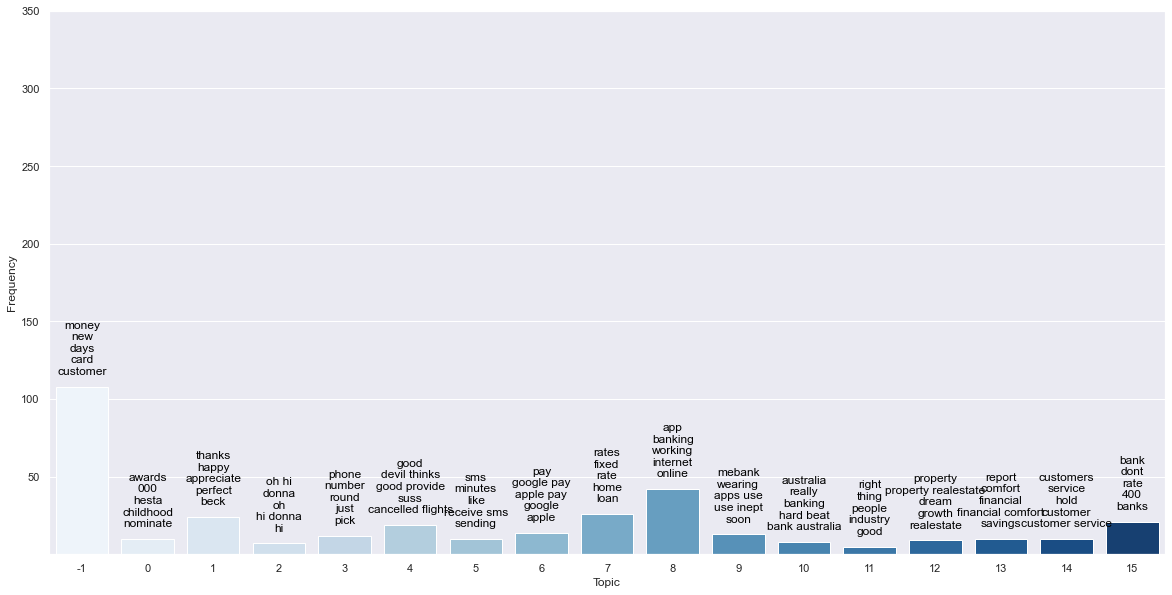

In [886]:
#plotting topics in the period 

data=clusters_2020.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

ax = sns.barplot(x="Topic", y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.yaxis.set_ticks([50,100,150,200,250,300,350])


fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.savefig("cluster_freqs.png")


for i in range(len(clusters_2020['Topic'])):

    n_topwords=5
    topwords=clusters_2020.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(clusters_2020.loc[i,'Topic']+1, clusters_2020.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2020.png")

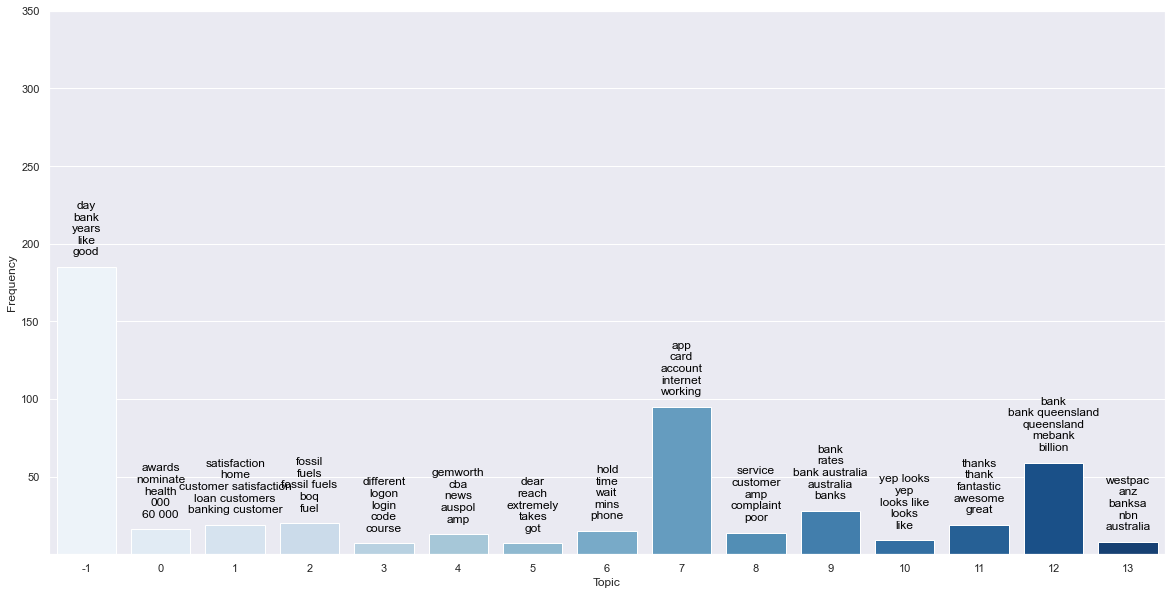

In [887]:
#plotting topics in the period 

data=clusters_2021.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

ax = sns.barplot(x="Topic", y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.yaxis.set_ticks([50,100,150,200,250,300,350])


fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.savefig("cluster_freqs.png")


for i in range(len(clusters_2021['Topic'])):

    n_topwords=5
    topwords=clusters_2021.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(clusters_2021.loc[i,'Topic']+1, clusters_2021.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2021.png")

In [952]:
data=clusters_2020.loc[:,['Topic','cluster_size','top_words']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

for i,topic in enumerate(data['Topic']):
    data.loc[i,'index']=i

data=data[1:12]

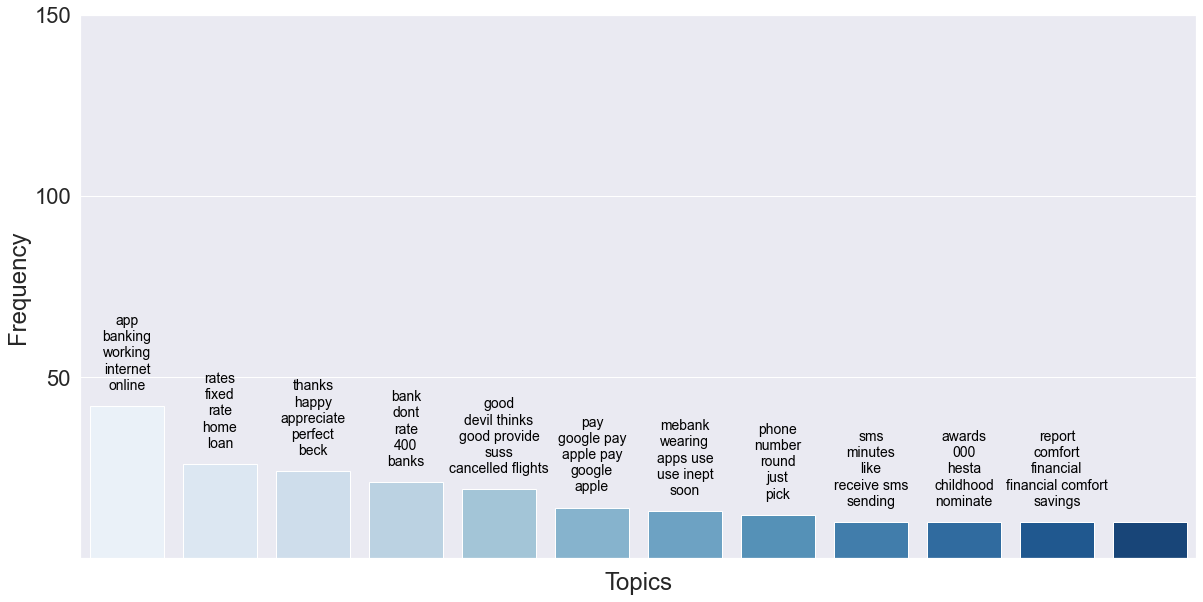

In [999]:
#plotting topics in the period 
ax = sns.barplot(x='index',y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.xaxis.set_label_text('Topics')
ax.set(xticklabels=[])

sns.set(font_scale=2) 
ax.yaxis.set_ticks([50,100,150])

fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)


for i in range(1,len(data['Topic'])): 

    #label='{}'.format(data.loc[i,'Topic'])
    n_topwords=5
    topwords=data.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(data.loc[i,'index']-1, data.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=14,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2020.png")

In [1216]:
data=clusters_2020.loc[:,['Topic','cluster_size','top_words_score']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

for i,topic in enumerate(data['Topic']):
    data.loc[i,'index']=i

data=data[1:13]
data

,Topic,cluster_size,top_words_score,index
1,8,42,"[('app', 0.06068483574541008), ('banking', 0.0...",1.0
2,7,26,"[('rates', 0.06159444333567206), ('fixed', 0.0...",2.0
3,1,24,"[('thanks', 0.1365620242497388), ('happy', 0.0...",3.0
4,15,21,"[('bank', 0.056224391764267405), ('dont', 0.02...",4.0
5,4,19,"[('good', 0.07136941498501952), ('devil thinks...",5.0
6,6,14,"[('pay', 0.07954368238745381), ('google pay', ...",6.0
7,9,13,"[('mebank', 0.15648961160490152), ('wearing', ...",7.0
8,3,12,"[('phone', 0.07842681681706848), ('number', 0....",8.0
9,5,10,"[('sms', 0.10348738736969179), ('minutes', 0.0...",9.0
10,0,10,"[('awards', 0.06922543370894715), ('000', 0.06...",10.0


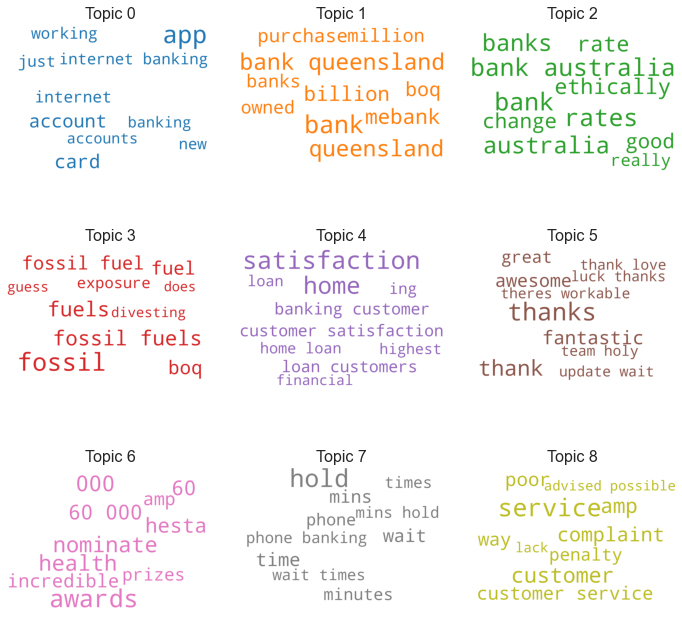

In [1024]:
# Wordcloud of Top N words in each topic
#!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


fig, axes = plt.subplots(3,3 , figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(ast.literal_eval(data.loc[i+1,'top_words_score'])[:10])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

fig.savefig("wordcloud_2021.png")


In [107]:
import json 
clustering_results.loc[1,'top_words_score']


"[('awards', 0.07246765771153867), ('000', 0.0606007944385828), ('hesta', 0.05569183870847809), ('nominate', 0.05569183870847809), ('000 prizes', 0.04458010449505674), ('prizes', 0.04458010449505674), ('amp', 0.04361798095312633), ('nominations', 0.04064984780876315), ('incredible', 0.04064984780876315), ('health', 0.04064984780876315)]"

# Reducing the number of clusters

Approach 1: merging smallest cluster with its most similar cluster 
(Note: this approach is not a good solution. Smaller does not necessary mean it is not a good cluster.)

In [1162]:
def merge_smallest_topic(data, docs_df, tf_idf):   
    #need to modify to update tweet and clsuter datasets to include new cluster names 
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

    return tf_idf, count, top_n_words

#topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

Approach 2: merging clusters with highest similarity metrics 

(Note: we can utilized different similarity metrics and features for this purpose. Here, we are using cosine similarity, with possibly a combination of extraxted tags, transformer embeddings, and umap projections. )

In [1163]:
def merge_most_similar_topic():            #need to modify to update tweet and clsuter datasets to include new cluster names 
	# Calculate cosine similarity
	similarities = cosine_similarity(tf_idf.T)
	np.fill_diagonal(similarities, 0)

	#TO INCLUDE THE MERGING CODE



# Cluster similarities

In [1274]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [1276]:
# Similarity Score based on TAGS (top keywords)

topic_similarities = cosine_similarity(tf_idf_2020.T)

In [1277]:
# Similarity Score based on Transformer Embeddings
cluster_embeddings=[]

for i,topic in enumerate(clustering_results_2020['Topic']):
	best_tweets_embeddings=results_2020[results_2020['cluster'].isin([topic]) & results_2020['cluster_probability'].isin([1.0, 0.0])]['embedding']
	cluster_embeddings.append(best_tweets_embeddings.mean(axis=0))
	#print(i, topic, best_tweets_embeddings.shape, cluster_embedding)
	#clustering_results_2020.loc[i,'sample_tweet']=best_tweet.values

cluster_embeddings=np.array(cluster_embeddings)
embedding_similarity = cosine_similarity(cluster_embeddings)


In [1278]:
# Similarity Score based on Transformer Embeddings
cluster_umap_projections=[]

for i,topic in enumerate(clustering_results_2020['Topic']):
	best_umap_projections=results_2020[results_2020['cluster'].isin([topic]) & results_2020['cluster_probability'].isin([1.0, 0.0])]['umap_projections']
	cluster_umap_projections.append(best_umap_projections.mean(axis=0))
	#print(i, topic, best_tweets_embeddings.shape, cluster_embedding)
	#clustering_results_2020.loc[i,'sample_tweet']=best_tweet.values

cluster_umap_projections=np.array(cluster_umap_projections)
umap_similarity = cosine_similarity(cluster_umap_projections)

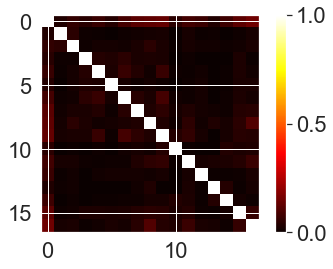

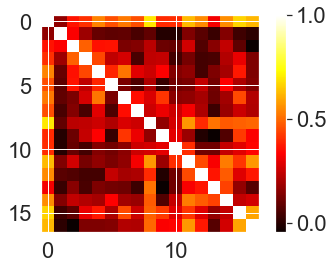

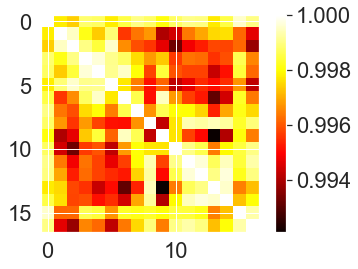

In [1280]:
#plotting similarity heatmaps
plt.imshow(topic_similarities, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(embedding_similarity, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(umap_similarity, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# BERTTopic

In [2687]:
#from sentence_transformers import SentenceTransformer

#model = SentenceTransformer("paraphrase-mpnet-base-v2")
#embeddings_clean = model.encode(input_data_clean["content_clean"].values)

In [2709]:
from bertopic import BERTopic

# Create BERTopic model
topic_model = BERTopic(nr_topics='auto',
		top_n_words=10,
                n_gram_range=(1,2), 
                calculate_probabilities=True,
                embedding_model=SentenceTransformer("paraphrase-mpnet-base-v2"),
                umap_model= umap_model,
                hdbscan_model=hdbscan_model,
                verbose=True)



docs=results_cluster_sorted['content_clean']
#embeddings=np.array(results_cluster_sorted['embedding'].values.tolist())

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(docs)

Batches: 100%|██████████| 27/27 [01:53<00:00,  4.19s/it]
2021-08-06 02:44:41,117 - BERTopic - Transformed documents to Embeddings
2021-08-06 02:44:44,117 - BERTopic - Reduced dimensionality with UMAP
2021-08-06 02:44:44,174 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-08-06 02:44:58,376 - BERTopic - Reduced number of topics from 22 to 9


In [2710]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,323,-1_you_for_is_your
1,0,297,0_for_is_on_bank
2,1,118,1_to_is_app_it
3,2,31,2_fossil_to fossil_fuel_fossil fuel
4,3,31,3_rates_interest_and_interest rates
5,4,20,4_they_data_for_and
6,5,17,5_go out_tap go_interest_tap
7,6,15,6_amp_very_high_their
8,7,10,7_problem_cleared_solved_incognito with


In [2715]:
results.head(1)

,date,content,content_clean,complaint,topic,embedding,umap_projections,cluster,cluster_probability,outlier_score
0,2020-07-27 07:35:23,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,0,NaN,"[-0.055616923, 0.0632461, -0.03989287, -0.1368...","[17.018082, 0.8446648, 7.1081824, 10.371539, 7...",11,0.563219,0.436781


In [2725]:
timestamps=results.date.to_list()
tweets=results.content_clean.to_list()

topics_over_time = topic_model.topics_over_time(tweets, topics, timestamps)


843it [07:06,  1.98it/s]


In [2744]:
topics_over_time.sample(10)

,Topic,Words,Frequency,Timestamp,Name
720,-1,"nothing ing, love with, shame was, getting rid...",1,2021-05-29 05:03:26,-1_you_for_is_your
425,-1,"msg every, delete transfer, deleted but, the t...",1,2021-02-10 07:47:17,-1_you_for_is_your
502,1,"stimulus driven, bumper profit, banks as, quee...",1,2021-02-23 02:50:21,1_to_is_app_it
786,5,"supersex with, had supersex, supersex, with yo...",1,2021-07-04 04:04:00,5_go out_tap go_interest_tap
180,3,"lnp, super funds, super, funds, politicians had",1,2020-10-14 08:30:12,3_rates_interest_and_interest rates
223,-1,"rate, fee, paid the, they jacked, pay them",1,2020-11-06 23:44:24,-1_you_for_is_your
83,5,"down, be down, its still, updated information,...",1,2020-08-27 01:36:40,5_go out_tap go_interest_tap
699,0,"and replied, replied now, for contact, have vi...",1,2021-05-18 06:14:41,0_for_is_on_bank
51,4,"is finally, finally available, when gpay, gpay...",1,2020-08-17 02:31:24,4_they_data_for_and
175,-1,"shefali, posoldova, are excited, kalsi shefali...",1,2020-10-13 01:34:05,-1_you_for_is_your


In [ ]:
#topic_model.visualize_topics_over_time(topics_over_time)

#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [2711]:
topic_model.visualize_topics()

# Top2Vec